# Prédiction des notes par les commentaires

## Import des modules

In [7]:
import numpy as np
import pandas as pd
from pymongo  import MongoClient
import re
import string
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.simplefilter("ignore")

## Connection à la base de données MongoDB

In [8]:

client = MongoClient(host="localhost", port=27017)
db_mongo = client.PLDAC_01
avis = db_mongo.avis

# avis

In [3]:
commentaires,notes = [],[]

for rep in avis.find({}):
  commentaire = rep['comment'] if 'comment' in rep else ""
  # lignes de commentaire vide sont ignorées
  if commentaire == "":
    continue
  
  note = rep['note']
  
  notes.append(note)
  commentaires.append(commentaire)
notes,commentaires = np.array(notes),np.array(commentaires)
print('notes:',len(notes),'commentaire:',len(commentaires))

notes: 0 commentaire: 0


## Estimation de densité de la distribution des notes

<Figure size 640x480 with 0 Axes>

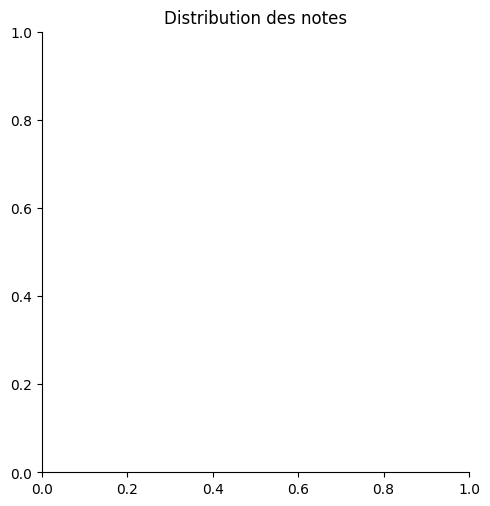

In [4]:
import seaborn as sns

plt.figure()
sns.displot(notes[:2000],kde=True)
plt.title('Distribution des notes')
plt.show()

<Figure size 640x480 with 0 Axes>

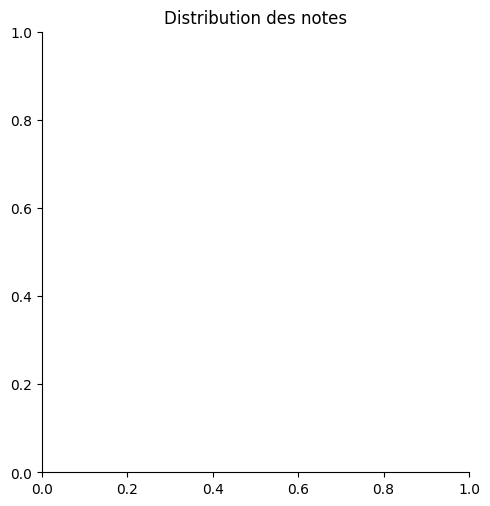

In [5]:
plt.figure()
sns.displot(notes,kde=True)
plt.title('Distribution des notes')
plt.show()

In [6]:
N = 100
X = notes.reshape((notes.size,1))
# préparer les points où on calculera la densité
X_plot = np.linspace(0, 10, 1000)[:, np.newaxis]

# estimation de densité par noyaux gaussiens
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
# calcul de la densité pour les données de X_plot
density = np.exp(kde.score_samples(X_plot)) * notes.size

# affichage : vraie densité et estimation
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(X[:,0], bins=10, fc='blue', alpha=0.2, label='Vraie densité')
ax.plot(X_plot[:,0], density, '-', label="Estimation",color='red')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')
ax.legend(loc='upper left')
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by KernelDensity.

## Prétraitement

In [ ]:
# fonction qui sup
def supprimer_les_nombres(docs):
    """ Fonction qui supprime tous les nombres dans la chaine de caractères doc

    Args:
        doc (string): chaine de caractère à emputer les nombres

    Returns:
        string: chaine de caractère sans les nombres
    """
    
    return np.array([re.sub('[0-9]+', '', doc) for doc in docs])

def supprimer_la_ponctuation(docs):
    """ Fonction qui supprime tous les nombres dans la chaine de caractères doc

    Args:
        doc (string): chaine de caractère à emputer les nombres

    Returns:
        string: chaine de caractère sans les nombres
    """
    
    punc = string.punctuation 
    punc += '\n\r\t'
    return np.array([doc.translate(str.maketrans(punc, ' ' * len(punc))) for doc in docs])

def pretraitement(docs):
    docs = np.array([doc.lower() for doc in docs])
    docs = supprimer_les_nombres(docs)
    docs = supprimer_la_ponctuation(docs)

    return docs
commentaires = pretraitement(commentaires)

In [ ]:
ch = np.array(['SofiA56','23NolwenN','34','SouleymanE62'])
pretraitement(ch)

In [ ]:
print(commentaires[0])

## Comptages des occurrences des mots et loi Zipf

In [ ]:
# loi Zipf 

vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(commentaires)  # creer le bow
sum_words = bag_of_words.sum(axis=0) # nb occurrences de chaque mot
words_freq = [(str(word), sum_words[0, idx]) for word, idx in     vectorizer.vocabulary_.items()] # couple (mot, freq)
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)  # trie par freq decroissante
print('nombre de mots:',len(words_freq))

nmots = 50
x = [w for w,f in words_freq[:nmots]]
y = [f for w,f in words_freq[:nmots]]

plt.figure()
plt.bar(x,y)
plt.axis('off')

### Les k mots les plus fréquents

In [ ]:
words_ord = [w for w,f in words_freq]
k = 200
print([w for w in words_ord[:k]])  # les k mots les plus fréquents

### Les k mots les moins fréquents

In [ ]:
# les moins fréquents majoritairement des erreurs de frappes et des exagérations
print([w for w in words_ord[-k:]])  # les k mots les moins fréquents

## Rééquilibrage des classes

In [ ]:
notes_en = np.around(notes)
notes_un,nb_notes = np.unique(notes_en,return_counts=True)
print('\n  Somme cumulée croissante:',np.cumsum(nb_notes)/nb_notes.sum())
print('Distribution des notes:',nb_notes)

N_min = np.min(nb_notes)
print('Minimum des notes:',N_min)
commentaires_eq,notes_eq = [],[]
notes_float_eq = []
for cl in notes_un:
  i_cl = notes_en == cl
  commentaires_cl = commentaires[i_cl]
  notes_cl = notes_en[i_cl]
  notes_float_cl = notes[i_cl]
  
  # Un petit shuffle
  i_rand = np.arange(commentaires_cl.shape[0])
  np.random.shuffle(i_rand)
  commentaires_cl = commentaires_cl[i_rand[:N_min]]

  # chaque classe présente N_min lignes
  for i in range(N_min): 
    commentaires_eq.append(commentaires_cl[i])
    notes_eq.append(notes_cl[i])
    notes_float_eq.append(notes_float_cl[i])

commentaires_eq,notes_eq = np.array(commentaires_eq),np.array(notes_eq)
notes_float_eq = np.array(notes_float_eq)
print('Nouvelle taille',len(commentaires_eq),len(notes_eq),N_min*notes_un.shape[0])

In [ ]:
print(len(commentaires_eq),len(notes_eq),N_min*notes_un.shape[0])


### Kde sur les classes rééquilibrées(juste pour voir)

In [ ]:
# Avec des notes float
plt.figure()
sns.displot(notes_float_eq,kde=True)
plt.title('Distribution des notes rééquilibrées')
plt.show()

In [ ]:
# Avec les notes en entier
plt.figure()
sns.displot(notes_eq,kde=True)
plt.title('Distribution des notes rééquilibrées')
plt.show()

## Mots les plus fréquents après rééquilibre

In [ ]:
# loi Zipf 

vectorizer = CountVectorizer()
bag_of_words_eq = vectorizer.fit_transform(commentaires_eq)  # creer le bow
sum_words_eq = bag_of_words_eq.sum(axis=0) # nb occurrences de chaque mot
words_freq_eq = [(str(word), sum_words_eq[0, idx]) for word, idx in     vectorizer.vocabulary_.items()] # couple (mot, freq)
words_freq_eq =sorted(words_freq_eq, key = lambda x: x[1], reverse=True)  # trie par freq decroissante
print('nombre de mots:',len(words_freq_eq))

nmots = 50
x = [w for w,f in words_freq_eq[:nmots]]
y = [f for w,f in words_freq_eq[:nmots]]

plt.figure()
plt.bar(x,y)
plt.axis('off')

In [ ]:
words_ord_eq = [w for w,f in words_freq_eq]
k = 200
print([w for w in words_ord_eq[:k] if w not in stopwords.words('french')])  # les k mots les plus fréquents

## Word cloud

### Word cloud de tous les commentaires(classes confondues)

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS # Note: this is the default option    

corpus = list(commentaires_eq)
corpus = " ".join(corpus)
# print(corpus[:50])
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Word cloud pour chaque classe

In [ ]:
k = 0 # les k motes les plus fréquents à ne pas considérer
for i in range(notes_un.shape[0]):
  
  # commentaires de chaque note
  i_commentaire_note = notes_eq == notes_un[i]
  commentaire_note = commentaires_eq[i_commentaire_note]
  
  # les mots les plus fréquent de chaque note
  corpus_note = " ".join(list(commentaire_note))
  wordcloud = WordCloud(background_color='white', stopwords = [w for w in words_ord[:k]], max_words=100).generate(corpus_note)

  plt.figure()
  plt.imshow(wordcloud)
  plt.title('note '+str(i))
  plt.axis('off')

### Word cloud de chaque classe sans les k mots les plus fréquents

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

k = 200 # les k motes les plus fréquents à ne pas considérer
stopwords_list = stopwords.words('french') + [w for w in words_ord[:k]]

for i in range(notes_un.shape[0]):
  
  # commentaires de chaque note
  i_commentaire_note = notes_eq == notes_un[i]
  commentaire_note = commentaires_eq[i_commentaire_note]
  
  # les mots les plus fréquent de chaque note
  corpus_note = " ".join(list(commentaire_note))
  wordcloud = WordCloud(background_color='white', stopwords = stopwords_list, max_words=100).generate(corpus_note)

  plt.figure()
  plt.imshow(wordcloud)
  plt.title('note '+str(i))
  plt.axis('off')

### Word cloud en biclasse sans les k mots les plus fréquents

In [ ]:
k = 200 # les k motes les plus fréquents à ne pas considérer
stopwords_list = stopwords.words('french') + [w for w in words_ord[:k]]

# commentaires des notes négatives
i_commentaire_note = notes_eq <= 5
commentaire_note = commentaires_eq[i_commentaire_note]

# les mots les plus fréquent de chaque note
corpus_note = " ".join(list(commentaire_note))
wordcloud = WordCloud(background_color='white', stopwords = stopwords_list, max_words=100).generate(corpus_note)

plt.figure()
plt.imshow(wordcloud)
plt.title('notes de 0 à 5')
plt.axis('off')
plt.show()

# commentaires des notes positives
i_commentaire_note = notes_eq > 5
commentaire_note = commentaires_eq[i_commentaire_note]

# les mots les plus fréquent de chaque note
corpus_note = " ".join(list(commentaire_note))
wordcloud = WordCloud(background_color='white', stopwords = stopwords_list, max_words=100).generate(corpus_note)

plt.figure()
plt.imshow(wordcloud)
plt.title('notes de 6 à 10')
plt.axis('off')
plt.show()

On voit des mots négatifs sur les petites notes (jamais,dommage,manque,ni,envie,pourtant,déçu,passe) et positifs(belle,possible,nouvelle,interaction,ressource,facile,objectif) dans les notes hautes.

## Prédiction des notes à partir des commentaires

In [ ]:
# séparation train test
from sklearn.model_selection import train_test_split

X,y = commentaires_eq,notes_eq
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0) 

tt = len(y_train)+len(y_test)
print(len(y_train)/tt,len(y_test)/tt)

In [ ]:
# Obtenir les caractéristiques les plus importantes pour un modèle
def mots_importants(model,n=10):
  feature_weights = model.coef_[0]
  top_features = {
      'positive': [vectorizer.get_feature_names_out()[i] for i in feature_weights.argsort()[-n:][::-1]],
      'negative': [vectorizer.get_feature_names_out()[i] for i in feature_weights.argsort()[:n]]
  }

  
  return top_features['positive'],top_features['negative']

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

def prediction(vect=CountVectorizer,**args):
  
  vectorizer = vect(**args)

  X = vectorizer.fit_transform(corpus)
  # print(vectorizer.get_feature_names()[:10]) # we only print a few
  print(X.shape)

  #Naïve Bayes
  nb_clf = MultinomialNB()
  nb_clf.fit(X, classes)


  #Logistic Regression
  lr_clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=1000,n_jobs=-1)
  lr_clf.fit(X, classes)

  #Linear SVM
  svm_clf = LinearSVC(random_state=0, tol=1e-5)
  svm_clf.fit(X, classes)


  X_t = vectorizer.transform(corpus_test)

  pred_nb = nb_clf.predict(X_t)
  pred_lr = lr_clf.predict(X_t)
  pred_svm = svm_clf.predict(X_t)


  print(f"Naïve Bayes accuracy: {accuracy_score(classes_test, pred_nb)}")
  print(f"Logistic Regression accuracy: {accuracy_score(classes_test, pred_lr)}")
  print(f"SVM accuracy: {accuracy_score(classes_test, pred_svm)}")

  return nb_clf,lr_clf,svm_clf

### Avec tous les mots du corpus

In [ ]:
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test
r = prediction(CountVectorizer)

Nous avons des performances meilleurs que celles de la fois fois.

### Sans les k=200 mots les plus fréquents

In [ ]:
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test
k = 200
r = prediction(CountVectorizer,stop_words=[w for w in words_ord[:k]])

### Sans les k=200 mots les plus fréquents et les 200 moins fréquents

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 200
r = prediction(CountVectorizer,stop_words=[w for w in words_ord[:k]] + [w for w in words_ord[-k:]])

### Sans les k=1_000 mots les plus fréquents

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 1_000
stopwords_list = stopwords.words('french') + [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
r = prediction(CountVectorizer,stop_words=stopwords_list)

### Sans les mots les plus fréquents du français

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 2_000
stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
r = prediction(CountVectorizer,stop_words=stopwords_list)



### Sans les k=2_000 mots les plus fréquents

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 2_000
stopwords_list = [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
r = prediction(CountVectorizer,stop_words=stopwords_list)

### avec des bigrammes

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 200
# stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
stopwords_list = [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]

r = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(1,2))


### Avec des trigrammes

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 200
# stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
stopwords_list = [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]

r = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(1,3))


### bigrammes et trigrammes

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
classes = y_train
corpus = X_train
classes_test = y_test
corpus_test = X_test

k = 200
# stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]
stopwords_list = [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]

r = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(2,3))


# Prédiction avec séparation des notes en deux classes

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
# classification binaire decoupage (0 à 5 -> -1) (6 à 10 -> 1)
classes = [1 if note>5 else -1 for note in y_train]
corpus = X_train
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = X_test

k = 200
stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)

### Les mots les plus importants

In [ ]:
mots_pos,mots_neg = mots_importants(lr_clf)
print('Mots positifs :',mots_pos)
print('Mots negatifs :',mots_neg)

In [ ]:
mots_pos,mots_neg = mots_importants(svm_clf)
print('Mots positifs :',mots_pos)
print('Mots negatifs :',mots_neg)

### Prédiction avec séparation des notes en deux classes sans les k=200 moins fréquents

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
# classification binaire decoupage (0 à 5 -> -1) (6 à 10 -> 1)
classes = [1 if note>5 else -1 for note in y_train]
corpus = X_train
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = X_test

k = 200
stop_words = stopwords.words('french') + [w for w in words_ord[:k]] + [w for w in words_ord[-2*k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)


### Prédiction avec séparation des notes en deux classes sans les k=2_000 moins fréquents

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
# classification binaire decoupage (0 à 5 -> -1) (6 à 10 -> 1)
classes = [1 if note>5 else -1 for note in y_train]
corpus = X_train
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = X_test

k = 2000
stop_words = stopwords.words('french') + [w for w in words_ord[:k]] + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)


### En enlevant les 20_000 termes les fréquents

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
# classification binaire decoupage (0 à 5 -> -1) (6 à 10 -> 1)
classes = [1 if note>5 else -1 for note in y_train]
corpus = X_train
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = X_test

k = 20_000
stop_words = stopwords.words('french') + [w for w in words_ord[:k]] + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)


# Avec du steming

In [ ]:
from nltk.stem.snowball import FrenchStemmer

def stem(docs):
  docs_stem = []
  stemmer = FrenchStemmer()
  
  for i in range(docs.shape[0]):
    tokens = str(docs[i]).split()

    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = " ".join(stemmed_tokens)
    docs_stem.append(stemmed_text)
  
  return np.array(docs_stem)

commentaires_stem = stem(commentaires)
corpus_stem = stem(X_train)
corpus_test_stem = stem(X_test)

In [ ]:
print(commentaires[0],'\n  -->\n',commentaires_stem[0])

In [ ]:
print(X_train[0],'\n  -->\n',corpus_stem[0])

## Comptages des occurrences des mots et loi Zipf

In [ ]:
# loi Zipf 

vectorizer = CountVectorizer()
bag_of_words_stem = vectorizer.fit_transform(commentaires_stem)  # creer le bow
sum_words_stem = bag_of_words_stem.sum(axis=0) # nb occurrences de chaque mot
words_freq_stem = [(str(word), sum_words_stem[0, idx]) for word, idx in     vectorizer.vocabulary_.items()] # couple (mot, freq)
words_freq_stem =sorted(words_freq_stem, key = lambda x: x[1], reverse=True)  # trie par freq decroissante
print('nombre de mots:',len(words_freq_stem))

nmots = 50
x = [w for w,f in words_freq_stem[:nmots]]
y = [f for w,f in words_freq_stem[:nmots]]

plt.figure()
plt.bar(x,y)
plt.axis('off')

In [ ]:
words_ord_stem = [w for w,f in words_freq_stem]
k = 200
print([w for w in words_ord_stem[:k]])  # les k mots les plus fréquents

## Prédiction en biclasses

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
classes = [1 if note>5 else -1 for note in y_train]
corpus = corpus_stem
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = corpus_test_stem

k = 200
stopwords_list = stopwords.words('french') #+ [w for w in words_ord[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)


## steming sans les k mots les plus fréquents

In [ ]:
k = 200
stopwords_list =  [w for w in words_ord_stem[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list)


## steming plus bigramme

In [ ]:
k = 200
stopwords_list =  [w for w in words_ord_stem[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(1,2))


## steming plus trigramme

In [ ]:
k = 200
stopwords_list =  [w for w in words_ord_stem[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(1,3))


In [ ]:
k = 200
stopwords_list =  [w for w in words_ord_stem[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(2,2))


In [ ]:
k = 200
stopwords_list =  [w for w in words_ord_stem[:k]] # + [w for w in words_ord[-k:]]

nb_clf,lr_clf,svm_clf = prediction(CountVectorizer,stop_words=stopwords_list,ngram_range=(2,3))


## TfIdf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

use_idf=True
smooth_idf=True
sublinear_tf=False


In [ ]:
# apprentissage en supprimant les k mots les plus fréquents
# classification binaire decoupage (0 à 5 -> -1) (6 à 10 -> 1)
classes = [1 if note>5 else -1 for note in y_train]
corpus = X_train
classes_test = [1 if note>5 else -1 for note in y_test]
corpus_test = X_test

k = 200
stopwords_list =  [w for w in words_ord_stem[:k]]

nb_clf,lr_clf,svm_clf = prediction(TfidfVectorizer,stop_words=stopwords_list,use_idf= use_idf, smooth_idf=smooth_idf, sublinear_tf=sublinear_tf)

### Prédiction des notes avec la régression linéaire (pas satisfaisant)

In [ ]:
# apprentissage en supprimant les k mots les plus fréquents

classes = y_train
corpus = X_train

k = 2000
vectorizer = CountVectorizer(stop_words=[w for w in words_ord[:k]])

X = vectorizer.fit_transform(corpus)
# print(vectorizer.get_feature_names()[:10]) # we only print a few
X = X.toarray().astype(float)
X_t = vectorizer.transform(X_test)
X_t = X_t.toarray().astype(float)
print(X.shape)

#### Normalisation sur les colonnes

In [ ]:
def normalise(X,max_cols=[],min_cols=[]):
  if len(max_cols) == 0:
    max_cols = X.max(axis=0)  # max de chaque colonne
  if len(min_cols) == 0:
    min_cols = X.min(axis=0)  # min de chaque colonne

  for j in range(X.shape[1]):
    max_c,min_c = max_cols[j], min_cols[j]
    d = max_c - min_c
    for i in range(X.shape[0]):
      if d == 0:
        X[i,j] = 0  # pour eviter NaN
      else:
        X[i,j] = (X[i,j] - min_c) / d

  return X,max_cols,min_cols

In [ ]:
from sklearn.linear_model import LinearRegression

X_n,max_cols,min_cols = normalise(X)
lr = LinearRegression()
lr.fit(X_n, classes)

X_t_n,max_cols,min_cols = normalise(X_t,max_cols,min_cols)

pred_lr = lr.predict(X_t_n)

err = np.abs(y_test-pred_lr)
err = err.sum() / err.shape[0]

print(f"Linear Regression score: {err}")

## Clustering avec KMeans

In [ ]:
# on supprime les colonnes des mots frequents
k = 200
words_un = [w for w,f in words_freq[:k]]
nom_cols = [word for word, idx in vectorizer.vocabulary_.items() if word not in words_un]
i_cols = [idx for word, idx in vectorizer.vocabulary_.items() if word not in words_un]
bow = bag_of_words[:,i_cols]

print(len(nom_cols),len(i_cols),'\n',bag_of_words.shape,bow.shape)

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=100).fit(bow)
y_pred = kmeans.predict(bow)

In [ ]:
# Getting clusters:
l_cl_major = []
for c in range(n_clusters):
  i_cl = y_pred == c
  cls,nb_cls = np.unique(notes[i_cl],return_counts=True)
  i_cls_trie = np.argsort(nb_cls)
  c_major = cls[i_cls_trie[0]]
  l_cl_major.append(c_major)
  sum_words = bow[i_cl].sum(axis=0).tolist()[0]
  print('cluster:',c,'classe maj:',c_major,sum_words[:3])
  
  # recopie chaque mot le nombre de fois qu'il est présent dans le cluster
  corpus_cl = []
  for i in range(len(nom_cols)):
    corpus_cl += [nom_cols[i]] * sum_words[i]
  corpus_cl = " ".join(corpus_cl)
  wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus_cl)

  plt.figure()
  plt.imshow(wordcloud)
  plt.title(i_cls_trie[0])
  plt.axis('off')

## Visualisation en 2D

In [ ]:
# visualisation en 2d mais il ne passe, trop de temps puis il crache
k = 200
vectorizer = CountVectorizer(lowercase=True,stop_words=[w for w in words_ord[:k]])

corpus = list(commentaires_eq)
corpus = " ".join(corpus)
# print(corpus[:5],commentaires_eq[0])
Xu = vectorizer.fit_transform(commentaires_eq)
print(Xu.shape)

In [ ]:
Xu = Xu.toarray()
# U,S,V = np.linalg.svd(Xu.toarray(), full_matrices=False)
lam, V = np.linalg.eig(Xu.T@Xu)

# tri et sélection des 2 vecteurs associés aux 2 plus grandes valeurs propres 
lam_tries_arg = np.argsort(lam)
lam_2_max = np.sort(lam_tries_arg[-2:])
vp = (V[:,lam_2_max])
Xu2D = Xu @ vp

In [ ]:
# affichage (plot) avec un code couleur pour les classes
plt.figure()
for c in range(0,10+1):
  Xc = Xu2D[notes==c]
  plt.scatter(Xc[:,0],Xc[:,1])

plt.legend(np.arange(10+1))